In [1]:
import pandas as pd
from itertools import chain
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
def check_(x):
    try:
        y = float(x.replace(',', ''))
    except:
        y = x
        
    return y

In [3]:
#data = pd.read_csv('../data/591_shop_features.tsv', sep='\t')
#data.columns

In [4]:
data = pd.read_csv('../data/shops/591-datadb.tsv', sep='\t')
data.columns

Index(['house_index', 'user_index', '二級', 'town', 'name', 'rental_price',
       'size', 'floor', 'floor_b', 'address', '小巷0/大路1', 'longitude',
       'latitude', 'type', 'house_age', 'feature', 'MRT_within_1km',
       'Bus_within_1km', 'MRT_name', 'MRT_distance', 'feature2', '押金', '管理費',
       '車位', '租約', '裝潢', '裝潢_尚未裝潢', '裝潢_簡易裝潢', '裝潢_中檔裝潢', '裝潢_高檔裝潢', 'img_url',
       'url', 'shop_within_1km', '餐廳餐館', '其他綜合零售', '便利商店', '美容美髮服務', '日常用品零售',
       '飲料店業', '其他餐飲業'],
      dtype='object')

In [5]:
## area feature
area_data = pd.read_csv('../data/final_output/district_features.csv')
## second 
second_data = pd.read_csv('../data/final_output/second_district_features.csv')
## change columns
change_cols = ['0-14歲人口數', '15-24歲人口數', '25-39歲人口數', '40-64歲人口數', '65歲以上人口數']

area_data[change_cols] = second_data[change_cols]

# Feature processing

In [6]:
all_features = []
for fea in data['feature']:
    features = []
    [features.extend(i.split('：')) for i in fea.split('；')]
    all_features.extend(features)

cnt = Counter(all_features)

In [7]:
cnt.most_common(15)

[('生活機能', 461),
 ('近便利商店', 433),
 ('公園綠地', 345),
 ('傳統市場', 314),
 ('學校', 306),
 ('百貨公司', 217),
 ('醫療機構', 200),
 ('夜市附近交通', 194),
 ('附近交通', 65),
 ('醫療機構附近交通', 59),
 ('夜市', 54),
 ('學校附近交通', 54),
 ('NAN', 51),
 (' 台北火車站', 25),
 (' 松山火車站', 16)]

# preprocessing

In [8]:
def get_min_MRT(x):
    if pd.isnull(x):
        y = 0
    else:
        y = np.min([int(i) for i in str(x).split(',')])
        
    return y

data['MRT_distance'] = data['MRT_distance'].map(get_min_MRT)

In [9]:
## Type
#shop_features = data
shop_features = data[['town', 'rental_price', 'size', 'floor', '小巷0/大路1', 'longitude', 'latitude', 'house_age', 'MRT_distance',  'type', '裝潢', '車位',
                        '餐廳餐館', '其他綜合零售', '便利商店', '美容美髮服務', '日常用品零售', '飲料店業']]

In [10]:
one_hot_type = pd.get_dummies(shop_features['type'])
shop_features = shop_features.join(one_hot_type)
shop_features = shop_features.drop('type', axis=1)
shop_features = shop_features.rename(columns={'公寓': 'apartment', '別墅': 'villa', 
                                              '電梯大樓': 'mansion', '店面（店鋪）': 'store',
                                              '小巷0/大路1': 'road/alley'})

In [11]:
ss = {'尚未裝潢': 0, '簡易裝潢': 1, '中檔裝潢': 2, '高檔裝潢': 3}
shop_features['裝潢'] = shop_features['裝潢'].map(lambda x: ss[x])

In [12]:
one_hot_type = pd.get_dummies(shop_features['車位'].map(lambda x: x.split('，')[0]))
shop_features = shop_features.join(one_hot_type)
shop_features = shop_features.drop('車位', axis=1)
shop_features = shop_features.rename(columns={'無': '無車位'})
shop_features = shop_features.drop(columns=['平面式停車位', '機械式停車位'])

In [13]:
shop_features['rental_price'] = shop_features['rental_price'].map(check_)

In [14]:
shop_features.columns

Index(['town', 'rental_price', 'size', 'floor', 'road/alley', 'longitude',
       'latitude', 'house_age', 'MRT_distance', '裝潢', '餐廳餐館', '其他綜合零售', '便利商店',
       '美容美髮服務', '日常用品零售', '飲料店業', 'apartment', 'villa', 'store', '透天厝',
       'mansion', '無車位'],
      dtype='object')

In [15]:
area_features = area_data[['TOWN', '0-14歲人口數', '15-24歲人口數',  '25-39歲人口數', '40-64歲人口數', '65歲以上人口數', 
              'DAY_WORK(7:00~13:00)', 'DAY_WORK(13:00~19:00)', 'NIGHT_WORK', 
              'DAY_WEEKEND(7:00~13:00)', 'DAY_WEEKEND(13:00~19:00)', 'NIGHT_WEEKEND']]
area_features = area_features.set_index('TOWN')

In [16]:
area_features.columns

Index(['0-14歲人口數', '15-24歲人口數', '25-39歲人口數', '40-64歲人口數', '65歲以上人口數',
       'DAY_WORK(7:00~13:00)', 'DAY_WORK(13:00~19:00)', 'NIGHT_WORK',
       'DAY_WEEKEND(7:00~13:00)', 'DAY_WEEKEND(13:00~19:00)', 'NIGHT_WEEKEND'],
      dtype='object')

In [17]:
new_features = []
for index, item in shop_features.iterrows():
    tmp = area_features.loc[item['town']]
    
    new_features.append(pd.concat((item, tmp)))
    #new_features.append(item)
    
new_features = pd.DataFrame(new_features)
new_features = new_features.drop(columns=['town', 'floor'])

In [18]:
new_features = new_features.applymap(check_)

In [19]:
new_features.columns

Index(['rental_price', 'size', 'road/alley', 'longitude', 'latitude',
       'house_age', 'MRT_distance', '裝潢', '餐廳餐館', '其他綜合零售', '便利商店', '美容美髮服務',
       '日常用品零售', '飲料店業', 'apartment', 'villa', 'store', '透天厝', 'mansion',
       '無車位', '0-14歲人口數', '15-24歲人口數', '25-39歲人口數', '40-64歲人口數', '65歲以上人口數',
       'DAY_WORK(7:00~13:00)', 'DAY_WORK(13:00~19:00)', 'NIGHT_WORK',
       'DAY_WEEKEND(7:00~13:00)', 'DAY_WEEKEND(13:00~19:00)', 'NIGHT_WEEKEND'],
      dtype='object')

In [20]:
#new_features.to_csv("591shop_area.tsv", sep="\t", index=None)

In [21]:
new_features['rental_price'] = np.log(new_features['rental_price'])
new_features['size'] = np.log(new_features['size'])

In [22]:
## categorical & numerical
categorical_columns = ['road/alley', 'apartment', 'villa', 'store', '透天厝', 'mansion', '無車位']
cate_embedding = new_features[categorical_columns]

In [23]:
## min/max normalization
embedding = (new_features - new_features.min()) / (new_features.max() - new_features.min())
embedding = embedding.drop(columns=categorical_columns)
embedding = pd.concat((embedding, cate_embedding), axis=1)

In [24]:
## Get mean and std
feature_mean = new_features.mean().drop(columns=categorical_columns)
feature_std = new_features.std().drop(columns=categorical_columns)
feature_min = new_features.min().drop(columns=categorical_columns)
feature_max = new_features.max().drop(columns=categorical_columns)

In [25]:
statics_info = pd.concat((feature_mean, feature_std, feature_min, feature_max),axis=1).rename(columns={0: 'mean', 1: 'std', 2: 'min', 3: 'max'}).drop(index=categorical_columns)
statics_info.index.name = 'feature_name'
statics_info.to_csv('../data/shops/embedding_statics.csv')

In [26]:
embedding = pd.concat((data[['house_index']], embedding), axis=1)
embedding.to_csv('../data/shops/shop_embedding.csv', index=None)

In [25]:
embedding.columns

Index(['rental_price', 'size', 'longitude', 'latitude', 'house_age',
       'MRT_distance', '裝潢', '餐廳餐館', '其他綜合零售', '便利商店', '美容美髮服務', '日常用品零售',
       '飲料店業', '0-14歲人口數', '15-24歲人口數', '25-39歲人口數', '40-64歲人口數', '65歲以上人口數',
       'DAY_WORK(7:00~13:00)', 'DAY_WORK(13:00~19:00)', 'NIGHT_WORK',
       'DAY_WEEKEND(7:00~13:00)', 'DAY_WEEKEND(13:00~19:00)', 'NIGHT_WEEKEND',
       'road/alley', 'apartment', 'villa', 'store', '透天厝', 'mansion', '無車位'],
      dtype='object')

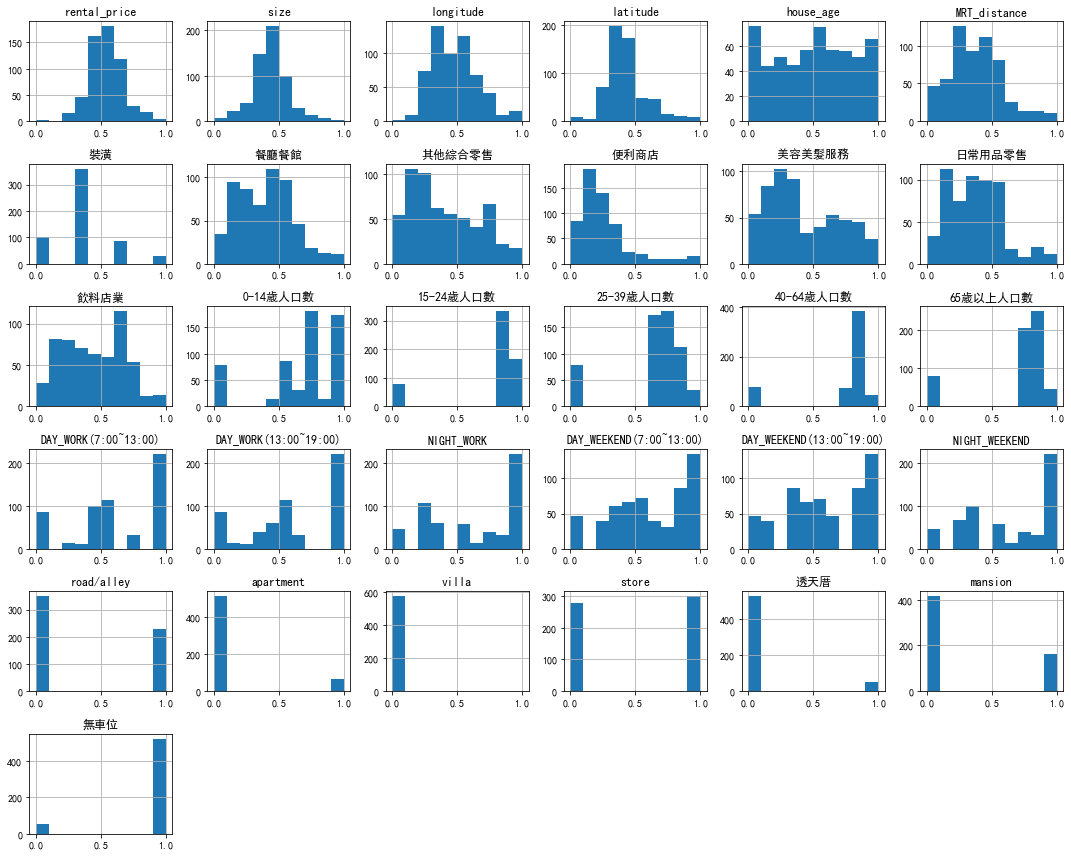

In [27]:
#embedding = embedding.drop(columns=['house_index'])
embedding.hist(figsize=(15, 12))
plt.tight_layout()
plt.show()

# Testing

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
scores = np.squeeze(cosine_similarity(embedding, embedding.iloc[[0]]))
scores = (scores + 1) * 50
index = np.argsort(scores)[::-1]
embedding.iloc[index]
#print(scores[index])

,rental_price,size,longitude,latitude,house_age,MRT_distance,裝潢,餐廳餐館,其他綜合零售,便利商店,...,DAY_WEEKEND(7:00~13:00),DAY_WEEKEND(13:00~19:00),NIGHT_WEEKEND,road/alley,apartment,villa,store,透天厝,mansion,無車位
0,0.417871,0.334358,0.561168,0.380471,0.84375,0.263959,0.333333,0.591281,0.725806,0.307692,...,1.000000,1.000000,1.00000,1,0,0,0,0,1,1
471,0.439953,0.369878,0.561168,0.380471,0.68750,0.263959,0.333333,0.591281,0.725806,0.307692,...,1.000000,1.000000,1.00000,1,0,0,0,0,1,1
52,0.665325,0.406931,0.561168,0.380471,0.81250,0.263959,0.333333,0.591281,0.725806,0.307692,...,1.000000,1.000000,1.00000,1,0,0,0,0,1,1
509,0.371607,0.306807,0.561168,0.380471,0.71875,0.263959,0.666667,0.591281,0.725806,0.307692,...,1.000000,1.000000,1.00000,1,0,0,0,0,1,1
163,0.693246,0.485455,0.527429,0.366517,0.81250,0.400000,0.333333,0.634877,0.709677,0.179487,...,1.000000,1.000000,1.00000,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,0.722252,0.676685,0.978996,0.446660,0.12500,0.436548,0.000000,0.114441,0.112903,0.051282,...,0.023735,0.024774,0.00000,1,0,0,1,0,0,0
554,0.399200,0.524554,0.135510,1.000000,0.50000,0.517766,0.000000,0.100817,0.064516,0.153846,...,0.501829,0.368256,0.56919,0,0,0,0,1,0,1
128,0.676869,0.555583,0.978996,0.446660,0.00000,0.436548,0.000000,0.114441,0.112903,0.051282,...,0.023735,0.024774,0.00000,1,0,0,1,0,0,0
139,0.472614,0.477970,0.019718,0.920059,0.25000,0.405076,0.333333,0.038147,0.000000,0.051282,...,0.501829,0.368256,0.56919,0,0,0,1,0,0,1


# Visualization

In [30]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [31]:
pca_results = PCA(n_components=2).fit_transform(embedding)
tsne_results = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=20).fit_transform(embedding)

/home/jasonluo/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


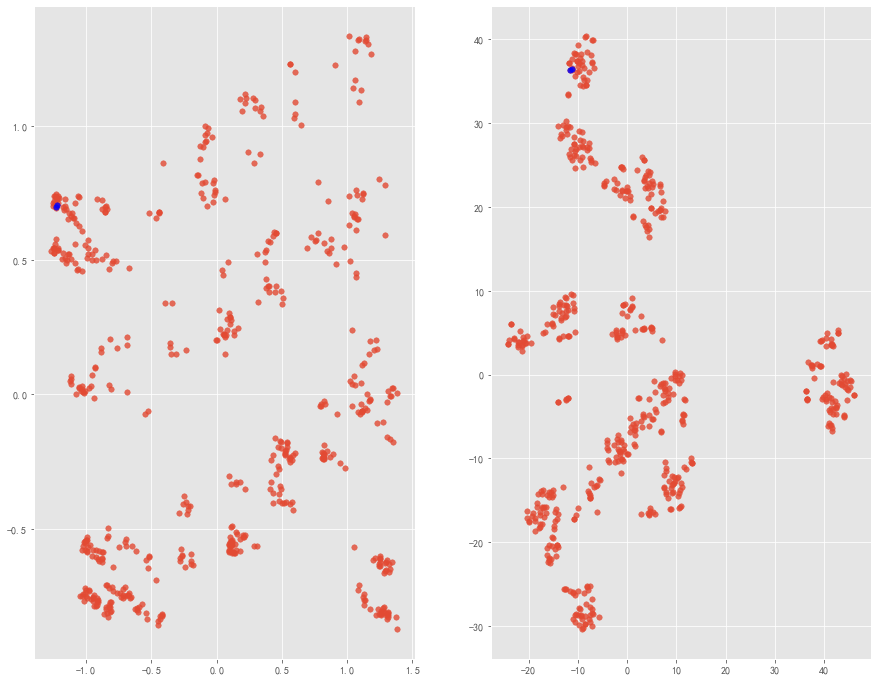

In [32]:
plt.style.use('ggplot')
plt.figure(figsize=(15, 12))

plt.subplot(1, 2, 1)
sc = plt.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.8, s=30)#, cmap='rainbow')

sc = plt.scatter(pca_results[0, 0], pca_results[0, 1], alpha=0.8, s=30, color='blue')#, cmap='rainbow')
sc = plt.scatter(pca_results[471, 0], pca_results[471, 1], alpha=0.8, s=30, color='blue')#, cmap='rainbow')

plt.subplot(1, 2, 2)
sc = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.8, s=30)#, cmap='rainbow')

sc = plt.scatter(tsne_results[0, 0], tsne_results[0, 1], alpha=0.8, s=30, color='blue')#, cmap='rainbow')
sc = plt.scatter(tsne_results[471, 0], tsne_results[471, 1], alpha=0.8, s=30, color='blue')#, cmap='rainbow')


plt.show()

In [ ]:
import tensorflow as tf